In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Multimodal Retrieval Augmented Generation (RAG) using Vertex AI Gemini API

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/retrieval-augmented-generation/intro_multimodal_rag.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Fuse-cases%2Fretrieval-augmented-generation%2Fintro_multimodal_rag.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/retrieval-augmented-generation/intro_multimodal_rag.ipynb">
      <img width="32px" src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/retrieval-augmented-generation/intro_multimodal_rag.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>    
</table>

| | |
|-|-|
|Author(s) | [Lavi Nigam](https://github.com/lavinigam-gcp) |

<div class="alert alert-block alert-warning">
<b>⚠️ There is a new version of this notebook with new data and some modifications here:  ⚠️</b>
</div>

[**building_DIY_multimodal_qa_system_with_mRAG.ipynb**](https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/qa-ops/building_DIY_multimodal_qa_system_with_mRAG.ipynb)

You can, however, still use this notebook as it is fully functional and has updated Gemini and text-embedding models.

## Overview

Retrieval augmented generation (RAG) has become a popular paradigm for enabling LLMs to access external data and also as a mechanism for grounding to mitigate against hallucinations.

In this notebook, you will learn how to perform multimodal RAG where you will perform Q&A over a financial document filled with both text and images.

### Gemini

Gemini is a family of generative AI models developed by Google DeepMind that is designed for multimodal use cases. The Gemini API gives you access to the Gemini 1.0 Pro Vision and Gemini 1.0 Pro models.

### Comparing text-based and multimodal RAG

Multimodal RAG offers several advantages over text-based RAG:

1. **Enhanced knowledge access:** Multimodal RAG can access and process both textual and visual information, providing a richer and more comprehensive knowledge base for the LLM.
2. **Improved reasoning capabilities:** By incorporating visual cues, multimodal RAG can make better informed inferences across different types of data modalities.

This notebook shows you how to use RAG with Vertex AI Gemini API, [text embeddings](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/text-embeddings), and [multimodal embeddings](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/multimodal-embeddings), to build a document search engine.

Through hands-on examples, you will discover how to construct a multimedia-rich metadata repository of your document sources, enabling search, comparison, and reasoning across diverse information streams.

### Objectives

This notebook provides a guide to building a document search engine using multimodal retrieval augmented generation (RAG), step by step:

1. Extract and store metadata of documents containing both text and images, and generate embeddings the documents
2. Search the metadata with text queries to find similar text or images
3. Search the metadata with image queries to find similar images
4. Using a text query as input, search for contextual answers using both text and images

### Costs

This tutorial uses billable components of Google Cloud:

- Vertex AI

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Getting Started

### Install Vertex AI SDK for Python and other dependencies

In [39]:
! pip3 install --upgrade --user google-cloud-aiplatform pymupdf rich colorama

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench) or [Colab Enterprise](https://cloud.google.com/colab/docs).

In [1]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Define Google Cloud project information

In [ ]:
# Define project information

import sys

PROJECT_ID = "YOUR_PROJECT_ID"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# if not running on Colab, try to get the PROJECT_ID automatically
if "google.colab" not in sys.modules:
    import subprocess

    PROJECT_ID = subprocess.check_output(
        ["gcloud", "config", "get-value", "project"], text=True
    ).strip()

print(f"Your project ID is: {PROJECT_ID}")

In [2]:
import sys

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries

In [34]:
from IPython.display import Markdown, display
from rich.markdown import Markdown as rich_Markdown
from vertexai.generative_models import (
    Content,
    GenerationConfig,
    GenerationResponse,
    GenerativeModel,
    HarmCategory,
    HarmBlockThreshold,
    Image,
    Part,
)

### Load the Gemini 1.5 Pro and Gemini 1.5 Flash models

In [4]:
text_model = GenerativeModel("gemini-1.5-pro")
multimodal_model = GenerativeModel("gemini-1.5-pro-001")
multimodal_model_flash = GenerativeModel("gemini-1.5-flash-001")

### Download custom Python utilities & required files

The cell below will download a helper functions needed for this notebook, to improve readability. It also downloads other required files. You can also view the code for the utils here: (`intro_multimodal_rag_utils.py`) directly on [GitHub](https://storage.googleapis.com/github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_old_version/intro_multimodal_rag_utils.py).

In [6]:
# download documents and images used in this notebook
!gsutil -m rsync -r gs://github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_old_version .
print("Download completed")


both the source and destination. Your crcmod installation isn't using the
module's C extension, so checksumming will run very slowly. If this is your
first rsync since updating gsutil, this rsync can take significantly longer than
usual. For help installing the extension, please see "gsutil help crcmod".

Building synchronization state...
Starting synchronization...
Copying gs://github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_old_version/data/google-10k-sample-part2.pdf...
Copying gs://github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_old_version/class_a_share.png...
Copying gs://github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_old_version/intro_multimodal_rag_utils.py...
Copying gs://github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_old_version/data/google-10k-sample-part1.pdf...
Copying gs://github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_old_version/tac_table_revenue.png...
/ [5/5 files][882.3 KiB/882.3 KiB] 100% Done                    

## Building metadata of documents containing text and images

### The data

The source data that you will use in this notebook is a modified version of [Google-10K](https://abc.xyz/assets/investor/static/pdf/20220202_alphabet_10K.pdf) which provides a comprehensive overview of the company's financial performance, business operations, management, and risk factors. As the original document is rather large, you will be using a modified version with only 14 pages, split into two parts - [Part 1](https://storage.googleapis.com/github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_old_version/data/google-10k-sample-part1.pdf) and [Part 2](https://storage.googleapis.com/github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_old_version/data/google-10k-sample-part2.pdf) instead. Although it's truncated, the sample document still contains text along with images such as tables, charts, and graphs.

### Import helper functions to build metadata

Before building the multimodal RAG system, it's important to have metadata of all the text and images in the document. For references and citations purposes, the metadata should contain essential elements, including page number, file name, image counter, and so on. Hence, as a next step, you will generate embeddings from the metadata, which will is required to perform similarity search when querying the data.

In [5]:
from intro_multimodal_rag_utils import get_document_metadata

### Extract and store metadata of text and images from a document

You just imported a function called `get_document_metadata()`. This function extracts text and image metadata from a document, and returns two dataframes, namely *text_metadata* and *image_metadata*, as outputs. If you want to find out more about how `get_document_metadata()` function is implemented using Gemini and the embedding models, you can take look at the [source code](https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/retrieval-augmented-generation/utils/intro_multimodal_rag_utils.py) directly.

The reason for extraction and storing both text metadata and image metadata is that just by using either of the two alone is not sufficient to come out with a relevent answer. For example, the relevant answers could be in visual form within a document, but text-based RAG won't be able to take into consideration of the visual images. You will also be exploring this example later in this notebook.

At the next step, you will use the function to extract and store metadata of text and images froma document. Please note that the following cell may take a few minutes to complete:

Note:

The current implementation works best:

* if your documents are a combination of text and images.
* if the tables in your documents are available as images.
* if the images in the document don't require too much context.

Additionally,

* If you want to run this on text-only documents, use normal RAG
* If your documents contain particular domain knowledge, pass that information in the prompt below.

<div class="alert alert-block alert-warning">
<b>⚠️ Do not send more than 50 pages in the logic below, its not degined to do that and you will get into quota issue. ⚠️</b>
</div>

In [6]:
# Specify the PDF folder with multiple PDF

# pdf_folder_path = "/content/data/" # if running in Google Colab/Colab Enterprise
pdf_folder_path = "data/"  # if running in Vertex AI Workbench.

# Specify the image description prompt. Change it
image_description_prompt = """Explain what is going on in the image.
If it's a table, extract all elements of the table.
If it's a graph, explain the findings in the graph.
Do not include any numbers that are not mentioned in the image.
"""

# Extract text and image metadata from the PDF document
text_metadata_df, image_metadata_df = get_document_metadata(
    multimodal_model,  # we are passing Gemini 1.5 Pro model
    pdf_folder_path,
    image_save_dir="images",
    image_description_prompt=image_description_prompt,
    embedding_size=1408,
    # add_sleep_after_page = True, # Uncomment this if you are running into API quota issues
    # sleep_time_after_page = 5,
    # generation_config = # see next cell
    # safety_settings =  # see next cell
)

print("\n\n --- Completed processing. ---")



 Processing the file: --------------------------------- data/google-10k-sample-part1.pdf 


Processing page: 1
Processing page: 2
Extracting image from page: 2, saved as: images/google-10k-sample-part1.pdf_image_1_0_11.jpeg
Processing page: 3
Extracting image from page: 3, saved as: images/google-10k-sample-part1.pdf_image_2_0_15.jpeg
Processing page: 4
Extracting image from page: 4, saved as: images/google-10k-sample-part1.pdf_image_3_0_18.jpeg
Processing page: 5
Extracting image from page: 5, saved as: images/google-10k-sample-part1.pdf_image_4_0_21.jpeg
Processing page: 6
Processing page: 7


 Processing the file: --------------------------------- data/google-10k-sample-part2.pdf 


Processing page: 1
Extracting image from page: 1, saved as: images/google-10k-sample-part2.pdf_image_0_0_6.jpeg
Extracting image from page: 1, saved as: images/google-10k-sample-part2.pdf_image_0_1_8.jpeg
Processing page: 2
Extracting image from page: 2, saved as: images/google-10k-sample-part2.pdf_ima

In [ ]:
# # Parameters for Gemini API call.
# # reference for parameters: https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/gemini

# generation_config=  GenerationConfig(temperature=0.2, max_output_tokens=2048)

# # Set the safety settings if Gemini is blocking your content or you are facing "ValueError("Content has no parts")" error or "Exception occurred" in your data.
# # ref for settings and thresholds: https://cloud.google.com/vertex-ai/docs/generative-ai/multimodal/configure-safety-attributes

# safety_settings = {
#                   HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
#                   HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
#                   HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
#                   HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
#                   }

# # You can also pass parameters and safety_setting to "get_gemini_response" function

#### Inspect the processed text metadata


The following cell will produce a metadata table which describes the different parts of text metadata, including:

- **text**: the original text from the page
- **text_embedding_page**: the embedding of the original text from the page
- **chunk_text**: the original text divided into smaller chunks
- **chunk_number**: the index of each text chunk
- **text_embedding_chunk**: the embedding of each text chunk

In [7]:
text_metadata_df.head()

,file_name,page_num,text,text_embedding_page,chunk_number,chunk_text,text_embedding_chunk
0,google-10k-sample-part1.pdf,1,source: https://abc.xyz/assets/investor/static...,"[0.06604167073965073, 0.054615460336208344, -0...",1,source: https://abc.xyz/assets/investor/static...,"[0.05712887644767761, 0.06096643581986427, -0...."
1,google-10k-sample-part1.pdf,1,source: https://abc.xyz/assets/investor/static...,"[0.06604167073965073, 0.054615460336208344, -0...",2,"of Record\nAs of December 31, 2021, there wer...","[0.030928857624530792, 0.02287178672850132, -0..."
2,google-10k-sample-part1.pdf,2,Issuer Purchases of Equity Securities\nThe fol...,"[0.035787057131528854, 0.008179700933396816, -...",1,Issuer Purchases of Equity Securities\nThe fol...,"[0.035787057131528854, 0.008179700933396816, -..."
3,google-10k-sample-part1.pdf,3,Stock Performance Graphs\nThe graph below matc...,"[0.04338429123163223, 0.024151558056473732, -0...",1,Stock Performance Graphs\nThe graph below matc...,"[0.04338429123163223, 0.024151558056473732, -0..."
4,google-10k-sample-part1.pdf,4,The graph below matches Alphabet Inc. Class A'...,"[0.05739395692944527, 0.02924434281885624, -0....",1,The graph below matches Alphabet Inc. Class A'...,"[0.05739395692944527, 0.02924434281885624, -0...."


#### Inspect the processed image metadata

The following cell will produce a metadata table which describes the different parts of image metadata, including:
* **img_desc**: Gemini-generated textual description of the image.
* **mm_embedding_from_text_desc_and_img**: Combined embedding of image and its description, capturing both visual and textual information.
* **mm_embedding_from_img_only**: Image embedding without description, for comparison with description-based analysis.
* **text_embedding_from_image_description**: Separate text embedding of the generated description, enabling textual analysis and comparison.

In [8]:
image_metadata_df.head()

,file_name,page_num,img_num,img_path,img_desc,mm_embedding_from_img_only,text_embedding_from_image_description
0,google-10k-sample-part1.pdf,2,1,images/google-10k-sample-part1.pdf_image_1_0_1...,The image is a table that shows the number of ...,"[0.0232503358, -0.000800505339, 0.0152765336, ...","[0.022681448608636856, 0.016109690070152283, 0..."
1,google-10k-sample-part1.pdf,3,1,images/google-10k-sample-part1.pdf_image_2_0_1...,The image is a line graph comparing the cumula...,"[0.0068904995, 0.0237238202, -0.00902639609, 0...","[0.012635421007871628, 0.029609661549329758, -..."
2,google-10k-sample-part1.pdf,4,1,images/google-10k-sample-part1.pdf_image_3_0_1...,The image is a line graph comparing the cumula...,"[0.0065851449, 0.010453077, -0.0087017715, 0.0...","[0.031192757189273834, 0.04452929273247719, -0..."
3,google-10k-sample-part1.pdf,5,1,images/google-10k-sample-part1.pdf_image_4_0_2...,The image is a table showing financial data fo...,"[0.01665527, 0.019989036, -0.0204045977, -0.01...","[0.03382618725299835, 0.04069436714053154, -0...."
4,google-10k-sample-part2.pdf,1,1,images/google-10k-sample-part2.pdf_image_0_0_6...,The image is a table showing percentages for d...,"[0.0357290804, 0.0324405842, 0.0125655765, -0....","[0.017558930441737175, 0.046305228024721146, -..."


### Import the helper functions to implement RAG

You will be importing the following functions which will be used in the remainder of this notebook to implement RAG:

* **get_similar_text_from_query():** Given a text query, finds text from the document which are relevant, using cosine similarity algorithm. It uses text embeddings from the metadata to compute and the results can be filtered by top score, page/chunk number, or embedding size.
* **print_text_to_text_citation():** Prints the source (citation) and details of the retrieved text from the `get_similar_text_from_query()` function.
* **get_similar_image_from_query():** Given an image path or an image, finds images from the document which are relevant. It uses image embeddings from the metadata.
* **print_text_to_image_citation():** Prints the source (citation) and the details of retrieved images from the `get_similar_image_from_query()` function.
* **get_gemini_response():** Interacts with a Gemini model to answer questions based on a combination of text and image inputs.
* **display_images():**  Displays a series of images provided as paths or PIL Image objects.

In [9]:
from intro_multimodal_rag_utils import (
    get_similar_text_from_query,
    print_text_to_text_citation,
    get_similar_image_from_query,
    print_text_to_image_citation,
    get_gemini_response,
    display_images,
)

Before implementing a multimodal RAG, let's take a step back and explore what you can achieve with just text or image embeddings alone. It will help to set the foundation for implementing a multimodal RAG, which you will be doing in the later part of the notebook. You can also use these essential elements together to build applications for multimodal use cases for extracting meaningful information from the document.

## Text Search

Let's start the search with a simple question and see if the simple text search using text embeddings can answer it. The expected answer is to show the value of basic and diluted net income per share of Google for different share types.

In [10]:
query = "I need details for basic and diluted net income per share of Class A, Class B, and Class C share for google?"

### Search similar text with text query

In [11]:
# Matching user text query with "chunk_embedding" to find relevant chunks.
matching_results_text = get_similar_text_from_query(
    query,
    text_metadata_df,
    column_name="text_embedding_chunk",
    top_n=3,
    chunk_text=True,
)

# Print the matched text citations
print_text_to_text_citation(matching_results_text, print_top=False, chunk_text=True)

Citation 1: Matched text: 

score:  0.76
file_name:  google-10k-sample-part2.pdf
page_number:  4
chunk_number:  1
chunk_text:  liquidation and dividend rights are identical, the undistributed earnings are
allocated on a proportionate basis.
In the years ended December 31, 2019, 2020 and 2021, the net income per
share amounts are the same for Class A, Class B, and Class C stock because
the holders of each class are entitled to equal per share dividends or distributions
in liquidation in accordance with the Amended and Restated Certificate of
Incorporation of Alphabet Inc.
The following tables set forth the computation of basic and diluted net income per
share of Class A, Class B, and Class C stock (in millions, except share amounts
which are reflected in thousands and per share amounts):

Citation 2: Matched text: 

score:  0.7
file_name:  google-10k-sample-part2.pdf
page_number:  3
chunk_number:  1
chunk_text:  increases in content acquisition costs primarily for YouTube, data center a

You can see that the first high score match does have what we are looking for, but upon closer inspection, it mentions that the information is available in the "following" table. The table data is available as an image rather than as text, and hence, the chances are you will miss the information unless you can find a way to process images and their data.

However, Let's feed the relevant text chunk across the data into the Gemini 1.0 Pro model and see if it can get your desired answer by considering all the chunks across the document. This is like basic text-based RAG implementation.

In [12]:
print("\n **** Result: ***** \n")

# All relevant text chunk found across documents based on user query
context = "\n".join(
    [value["chunk_text"] for key, value in matching_results_text.items()]
)

instruction = f"""Answer the question with the given context.
If the information is not available in the context, just return "not available in the context".
Question: {query}
Context: {context}
Answer:
"""

# Prepare the model input
model_input = instruction

# Generate Gemini response with streaming output
get_gemini_response(
    text_model,  # we are passing Gemini 1.0 Pro
    model_input=model_input,
    stream=True,
    generation_config=GenerationConfig(temperature=0.2),
)


 **** Result: ***** 



'not available in the context \n'

You can see that it returned:

*"The provided context does not include the details for basic and diluted net income per share of Class A, Class B, and Class C share for google.
"*

This is expected as discussed previously. No other text chunk (total 3) had the information you sought.
This is because the information is only available in the images rather than in the text part of the document. Next, let's see if you can solve this problem by leveraging Gemini 1.0 Pro Vision and Multimodal Embeddings.

Note: We handcrafted examples in our document to simulate real-world cases where information is often embedded in charts, table, graphs, and other image-based elements and unavailable as plain text.  

### Search similar images with text query

Since plain text search didn't provide the desired answer and the information may be visually represented in a table or another image format, you will use multimodal capability of Gemini 1.0 Pro Vision model for the similar task. The goal here also is to find an image similar to the text query. You may also print the citations to verify.

In [13]:
query = "I need details for basic and diluted net income per share of Class A, Class B, and Class C share for google?"


 **** Result: ***** 



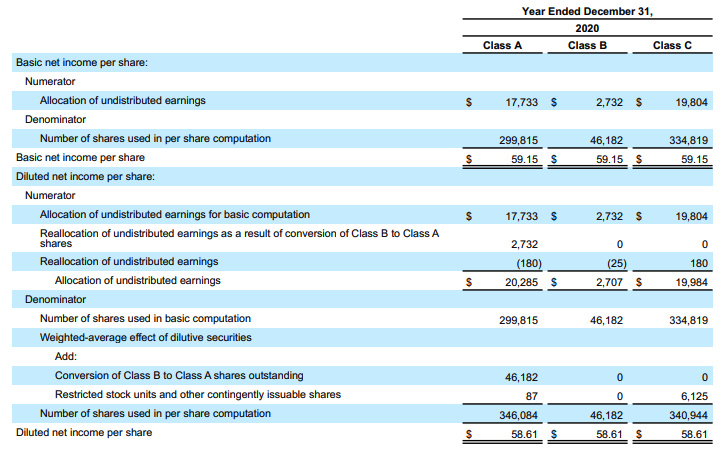

In [14]:
matching_results_image = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,
    column_name="text_embedding_from_image_description",  # Use image description text embedding
    image_emb=False,  # Use text embedding instead of image embedding
    top_n=3,
    embedding_size=1408,
)

# Markdown(print_text_to_image_citation(matching_results_image, print_top=True))
print("\n **** Result: ***** \n")

# Display the top matching image
display(matching_results_image[0]["image_object"])

Bingo! It found exactly what you were looking for. You wanted the details on Google's Class A, B, and C shares' basic and diluted net income, and guess what? This image fits the bill perfectly thanks to its descriptive metadata using Gemini.

You can also send the image and its description to Gemini 1.0 Pro Vision and get the answer as JSON:

In [16]:
print("\n **** Result: ***** \n")

# All relevant text chunk found across documents based on user query
context = f"""Image: {matching_results_image[0]['image_object']}
Description: {matching_results_image[0]['image_description']}
"""

instruction = f"""Answer the question in JSON format with the given context of Image and its Description. Only include value.
Question: {query}
Context: {context}
Answer:
"""

# Prepare the model input
model_input = instruction

# Generate Gemini response with streaming output
Markdown(
    get_gemini_response(
        multimodal_model_flash,  # we are passing Gemini 1.5 Pro Flash
        model_input=model_input,
        stream=True,
        generation_config=GenerationConfig(temperature=1),
    )
)


 **** Result: ***** 



```json
{
"Class A": {
"Basic Net Income Per Share": 59.15,
"Diluted Net Income Per Share": 58.61
},
"Class B": {
"Basic Net Income Per Share": 59.15,
"Diluted Net Income Per Share": 58.61
},
"Class C": {
"Basic Net Income Per Share": 59.15,
"Diluted Net Income Per Share": 58.61
}
}
```

In [17]:
## you can check the citations to probe further.
## check the "image description:" which is a description extracted through Gemini which helped search our query.
Markdown(print_text_to_image_citation(matching_results_image, print_top=True))

Citation 1: Matched image path, page number and page text: 

score:  0.73
file_name:  google-10k-sample-part2.pdf
path:  images/google-10k-sample-part2.pdf_image_4_0_22.jpeg
page number:  5
page text:  Stock-Based Award Activities
The weighted-average grant-date fair value of RSUs granted during the years
ended December 31, 2019 and 2020 was $1,092.36 and $1,407.97, respectively.
Total fair value of RSUs, as of their respective vesting dates, during the years
ended December 31, 2019, 2020, and 2021 were $15.2 billion, $17.8 billion, and
$28.8 billion, respectively. As of December 31, 2021, there was $25.8 billion of
unrecognized compensation cost related to unvested employee RSUs. This
amount is expected to be recognized over a weighted-average period of 2.5
years. 401(k) Plans We have two 401(k) Savings Plans that qualify as deferred

image description:  The image is a table showing the calculation of basic and diluted net income per share for different classes of shares (Class A, Cla

<IPython.core.display.Markdown object>

## Image Search

### Search similar image with image query

Imagine searching for images, but instead of typing words, you use an actual image as the clue. You have a table with numbers about the cost of revenue for two years, and you want to find other images that look like it, from the same document or across multiple documents.

Think of it like searching with a mini-map instead of a written address. It's a different way to ask, "Show me more stuff like this". So, instead of typing "cost of revenue 2020 2021 table", you show a picture of that table and say, "Find me more like this"

For demonstration purposes, we will only be finding similar images that show the cost of revenue or similar values in a single document below. However, you can scale this design pattern to match (find relevant images) across multiple documents.

***Input image from user:***


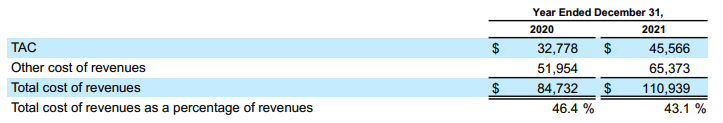

In [18]:
# You can find a similar image as per the images you have in the metadata.
# In this case, you have a table (picked from the same document source) and you would like to find similar tables in the document.
image_query_path = "tac_table_revenue.png"

# Print a message indicating the input image
print("***Input image from user:***")

# Display the input image
Image.load_from_file(image_query_path)

You expect to find tables (as images) that are similar in terms of "Other/Total cost of revenues."


 **** Result: ***** 



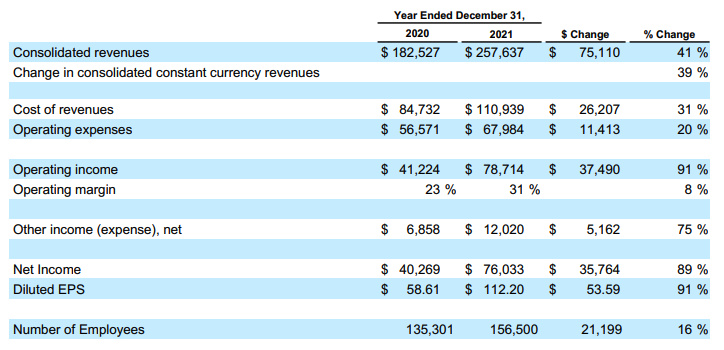

In [19]:
# Search for Similar Images Based on Input Image and Image Embedding

matching_results_image = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,  # Use query text for additional filtering (optional)
    column_name="mm_embedding_from_img_only",  # Use image embedding for similarity calculation
    image_emb=True,
    image_query_path=image_query_path,  # Use input image for similarity calculation
    top_n=3,  # Retrieve top 3 matching images
    embedding_size=1408,  # Use embedding size of 1408
)

print("\n **** Result: ***** \n")

# Display the Top Matching Image
display(
    matching_results_image[0]["image_object"]
)  # Display the top matching image object (Pillow Image)

It did find a similar-looking image (table), which gives more detail about different revenue, expenses, income, and a few more details based on the given image. More importantly, both tables show numbers related to the "cost of revenue."

You can also print the citation to see what it has matched.

In [20]:
# Display citation details for the top matching image
print_text_to_image_citation(
    matching_results_image, print_top=True
)  # Print citation details for the top matching image

Citation 1: Matched image path, page number and page text: 

score:  0.77
file_name:  google-10k-sample-part1.pdf
path:  images/google-10k-sample-part1.pdf_image_4_0_21.jpeg
page number:  5
page text:  Executive Overview
The following table summarizes consolidated financial results for the years ended
December 31, 2020 and 2021 unless otherwise specified (in millions, except for
per share information and percentages):
Revenues were $257.6 billion, an increase of 41%. The increase in
revenues was primarily driven by Google Services and Google Cloud. The
adverse effect of COVID-19 on 2020 advertising revenues also contributed
to the year-over-year growth.
Cost of revenues was $110.9 billion, an increase of 31%, primarily driven
by increases in TAC and content acquisition costs.
An overall increase in data centers and other operations costs was partially
offset by a reduction in depreciation expense due to the change in the
estimated useful life of our servers and certain network equipmen

---------------Matched Images------------------



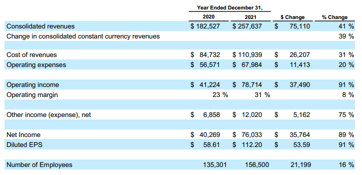

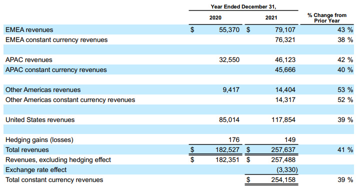

In [21]:
# Check Other Matched Images (Optional)
# You can access the other two matched images using:

print("---------------Matched Images------------------\n")
display_images(
    [
        matching_results_image[0]["img_path"],
        matching_results_image[1]["img_path"],
    ],
    resize_ratio=0.5,
)

The ability to identify similar text and images based on user input, using Gemini and embeddings, forms a crucial foundation for development of multimodal RAG systems, which you explore in the next section.

### Comparative reasoning

Next, let's apply what you have done so far to doing comparative reasoning.

For this example:

Step 1: You will search all the images for a specific query

Step 2: Send those images to Gemini 1.0 Pro Vision to ask multiple questions, where it has to compare and provide you with answers.

In [36]:
matching_results_image_query_1 = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query="Show me all the graphs that shows Google Class A cumulative 5-year total return",
    column_name="text_embedding_from_image_description",  # Use image description text embedding # mm_embedding_from_img_only text_embedding_from_image_description
    image_emb=False,  # Use text embedding instead of image embedding
    top_n=3,
    embedding_size=1408,
)

---------------Matched Images------------------



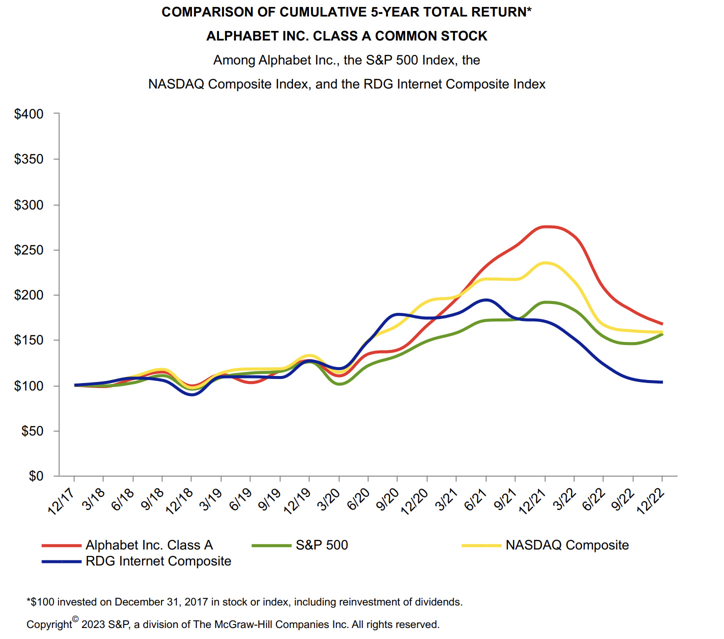

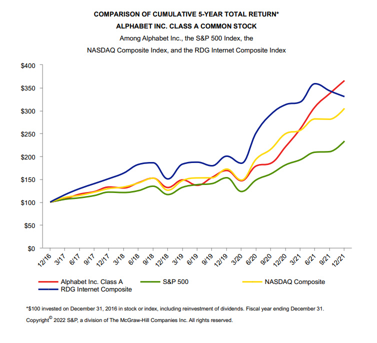

In [37]:
# Check Matched Images
# You can access the other two matched images using:

print("---------------Matched Images------------------\n")
display_images(
    [
        matching_results_image_query_1[0]["img_path"],
        matching_results_image_query_1[1]["img_path"],
    ],
    resize_ratio=0.5,
)

In [38]:
prompt = f""" Instructions: Compare the images and the Gemini extracted text provided as Context: to answer Question:
Make sure to think thoroughly before answering the question and put the necessary steps to arrive at the answer in bullet points for easy explainability.

Context:
Image_1: {matching_results_image_query_1[0]["image_object"]}
gemini_extracted_text_1: {matching_results_image_query_1[0]['image_description']}
Image_2: {matching_results_image_query_1[1]["image_object"]}
gemini_extracted_text_2: {matching_results_image_query_1[2]['image_description']}

Question:
 - Key findings of Class A share?
 - What are the critical differences between the graphs for Class A Share?
 - What are the key findings of Class A shares concerning the S&P 500?
 - Which index best matches Class A share performance closely where Google is not already a part? Explain the reasoning.
 - Identify key chart patterns in both graphs.
 - Which index best matches Class A share performance closely where Google is not already a part? Explain the reasoning.
"""

# Generate Gemini response with streaming output
rich_Markdown(
    get_gemini_response(
        multimodal_model,  # we are passing Gemini 1.5 Pro
        model_input=[prompt],
        stream=True,
        generation_config=GenerationConfig(temperature=1),
    )
)

Unfortunately, I cannot directly access or analyze the content of images or URLs, including the ones represented   
here as "<vertexai.generative_models._generative_models.Image object...>". My abilities are limited to processing  
and understanding the text provided.                                                                               

However, based on the text descriptions you've given:                                                              

Image 1 Analysis                                                                                                   

 • Key findings of Class A share?                                                                                  
    • To answer this, I need the actual performance trend from the line graph.  Was Alphabet Inc. Class A stock    
      generally up, down, or flat over the 5-year period? Did it experience any sharp rises or falls?              
 • What are the critical differences between the graphs for Class A Share?                                         
    • This question seems to imply there are multiple graphs for Class A shares within Image 1. The description    
      mentions only one line representing Class A shares.  Please clarify.                                         
 • What are the key findings of Class A shares concerning the S&P 500?                                             
    • This requires comparing the Class A share performance line to the S&P 500 line on the graph. Did Class A     
      shares outperform or underperform the S&P 500? Was the relationship consistent, or did it change over the 5  
      years?                                                                                                       
 • Which index best matches Class A share performance closely where Google is not already a part?                  
    • Again, I need the visual trend from the graph to make this comparison.  Ideally, you'd look for an index line
      that closely follows the shape and direction of the Class A share line, indicating a similar performance     
      pattern.                                                                                                     
 • Identify key chart patterns in both graphs.                                                                     
    • For the line graph (Image 1): Look for trends (upward, downward, flat), any significant spikes or dips, and  
      how the lines for different indices relate to each other.                                                    
    • For the table (Image 2):  Key patterns would involve analyzing the changes in unvested shares over time. For 
      example, was there a significant increase or decrease in granted shares or shares that were                  
      forfeited/canceled?                                                                                          

Image 2 Analysis                                                                                                   

 • This table focuses on Alphabet's employee stock options (RSUs), not directly on the performance of Class A      
   shares in the market.  It wouldn't be appropriate to compare or draw direct conclusions about Class A share     
   performance based on this table.                                                                                

To get a complete analysis, please provide:                                                                        

 • Clarification on multiple Class A graphs: If there's more than one representation of Class A shares in Image 1. 
 • Description of the line trends: Summarize how the lines move on the graph (e.g., "Class A shares rose sharply in
   2019, then plateaued...").                                                                                      

Let me know if you can provide more context, and I'll do my best to help!


<div class="alert alert-block alert-warning">
<b>⚠️ Disclaimer: This is not a real investment advise and should not be taken seriously!! ⚠️</b>
</div>

## Multimodal retrieval augmented generation (RAG)

Let's bring everything together to implement multimodal RAG. You will use all the elements that you've explored in previous sections to implement the multimodal RAG. These are the steps:

* **Step 1:** The user gives a query in text format where the expected information is available in the document and is embedded in images and text.
* **Step 2:** Find all text chunks from the pages in the documents using a method similar to the one you explored in `Text Search`.
* **Step 3:** Find all similar images from the pages based on the user query matched with `image_description` using a method identical to the one you explored in `Image Search`.
* **Step 4:** Combine all similar text and images found in steps 2 and 3 as `context_text` and `context_images`.
* **Step 5:** With the help of Gemini, we can pass the user query with text and image context found in steps 2 & 3. You can also add a specific instruction the model should remember while answering the user query.
* **Step 6:** Gemini produces the answer, and you can print the citations to check all relevant text and images used to address the query.

### Step 1: User query

In [25]:
# this time we are not passing any images, but just a simple text query.

query = """Questions:
 - What are the critical difference between various graphs for Class A Share?
 - Which index best matches Class A share performance closely where Google is not already a part? Explain the reasoning.
 - Identify key chart patterns for Google Class A shares.
 - What is cost of revenues, operating expenses and net income for 2020. Do mention the percentage change
 - What was the effect of Covid in the 2020 financial year?
 - What are the total revenues for APAC and USA for 2021?
 - What is deferred income taxes?
 - How do you compute net income per share?
 - What drove percentage change in the consolidated revenue and cost of revenue for the year 2021 and was there any effect of Covid?
 - What is the cause of 41% increase in revenue from 2020 to 2021 and how much is dollar change?
 """

### Step 2: Get all relevant text chunks

In [26]:
# Retrieve relevant chunks of text based on the query
matching_results_chunks_data = get_similar_text_from_query(
    query,
    text_metadata_df,
    column_name="text_embedding_chunk",
    top_n=10,
    chunk_text=True,
)

### Step 3: Get all relevant images

In [27]:
# Get all relevant images based on user query
matching_results_image_fromdescription_data = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,
    column_name="text_embedding_from_image_description",
    image_emb=False,
    top_n=10,
    embedding_size=1408,
)

### Step 4: Create context_text and context_images

In [28]:
# combine all the selected relevant text chunks
context_text = []
for key, value in matching_results_chunks_data.items():
    context_text.append(value["chunk_text"])
final_context_text = "\n".join(context_text)

# combine all the relevant images and their description generated by Gemini
context_images = []
for key, value in matching_results_image_fromdescription_data.items():
    context_images.extend(
        ["Image: ", value["image_object"], "Caption: ", value["image_description"]]
    )

### Step 5: Pass context to Gemini

In [35]:
prompt = f""" Instructions: Compare the images and the text provided as Context: to answer multiple Question:
Make sure to think thoroughly before answering the question and put the necessary steps to arrive at the answer in bullet points for easy explainability.
If unsure, respond, "Not enough context to answer".

Context:
 - Text Context:
 {final_context_text}
 - Image Context:
 {context_images}

{query}

Answer:
"""

# Generate Gemini response with streaming output
rich_Markdown(
    get_gemini_response(
        multimodal_model,
        model_input=[prompt],
        stream=True,
        generation_config=GenerationConfig(temperature=1),
    )
)

Here are the answers to your questions, broken down for clarity:                                                   

1. What are the critical difference between various graphs for Class A Share?                                      

 • Time Period: The provided text includes two different 5-year cumulative return graphs for Alphabet Inc. Class A 
   stock:                                                                                                          
    • December 31, 2016 to December 31, 2021                                                                       
    • December 31, 2017 to December 31, 2022                                                                       
 • Data Included:                                                                                                  
    • Both graphs compare Class A share performance to the S&P 500, NASDAQ Composite, and RDG Internet Composite.  
    • No other graphs specifically focusing on Class A shares are described in the text.                           

2. Which index best matches Class A share performance closely where Google is not already a part? Explain the      
reasoning.                                                                                                         

 • Not enough context to answer.                                                                                   
    • The text doesn't specify the composition of the RDG Internet Composite index. It's impossible to know if     
      Google is already a component of this index.                                                                 
    • To determine the closest matching index, we'd need to visually analyze the graphs and compare the slopes and 
      patterns of the lines representing each index against Alphabet Inc. Class A shares.                          

3. Identify key chart patterns for Google Class A shares.                                                          

 • Not enough context to answer.  We need to visually inspect the graphs to identify patterns (e.g., uptrends,     
   downtrends, consolidation periods).                                                                             

4. What is cost of revenues, operating expenses, and net income for 2020. Do mention the percentage change         

Here's the information from the provided text:                                                                     

 • Cost of Revenues (2020): $84,732 million                                                                        
 • Operating Expenses (2020): $56,571 million                                                                      
 • Net Income (2020): $40,269 million                                                                              

The text doesn't directly provide the percentage change for these items in 2020. It focuses on changes from 2020 to
2021.                                                                                                              

5. What was the effect of Covid in the 2020 financial year?                                                        

 • Reduced advertising revenue:  The text states that starting in March 2020, advertising revenue declined despite 
   increased search activity. This was attributed to:                                                              
    • Users searching for less commercially focused topics.                                                        
    • Advertisers reducing spending.                                                                               
 • Revenue decline in Q2 2020:  The text mentions a continued decline in advertising revenues for the quarter ended
   June 30, 2020.                                                                                                  

6. What are the total revenues for APAC and USA for 2021?                                                          

 • APAC Revenues (2021): $46,123 million  

### Step 6: Print citations and references

---------------Matched Images------------------



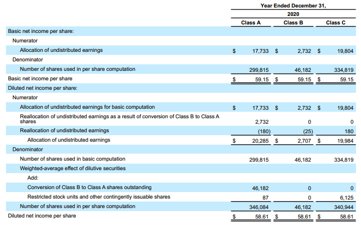

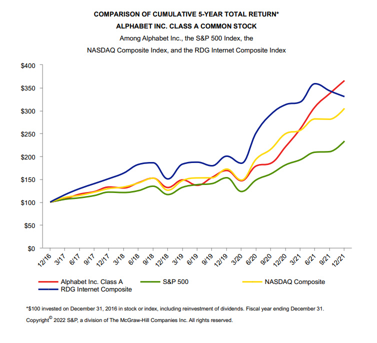

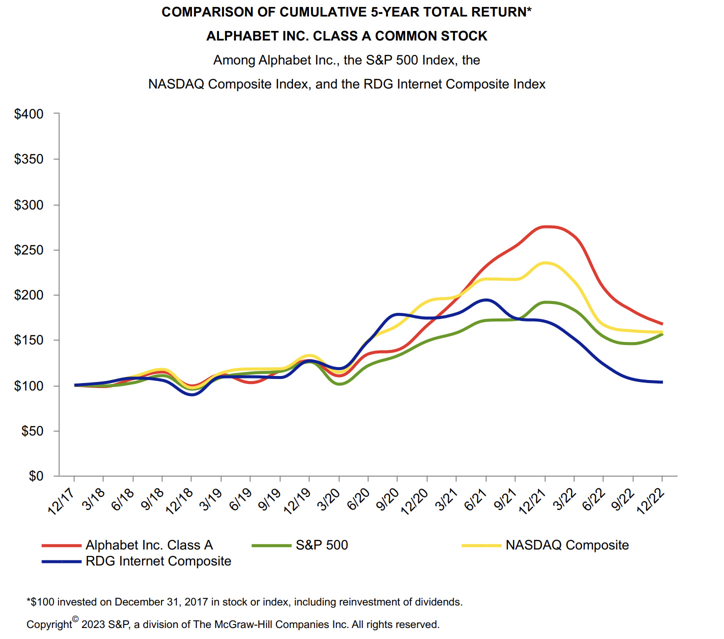

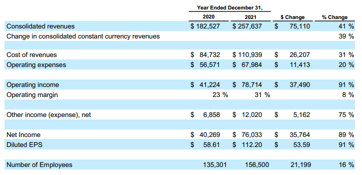

In [30]:
print("---------------Matched Images------------------\n")
display_images(
    [
        matching_results_image_fromdescription_data[0]["img_path"],
        matching_results_image_fromdescription_data[1]["img_path"],
        matching_results_image_fromdescription_data[2]["img_path"],
        matching_results_image_fromdescription_data[3]["img_path"],
    ],
    resize_ratio=0.5,
)

In [31]:
# Image citations. You can check how Gemini generated metadata helped in grounding the answer.

print_text_to_image_citation(
    matching_results_image_fromdescription_data, print_top=False
)

Citation 1: Matched image path, page number and page text: 

score:  0.66
file_name:  google-10k-sample-part2.pdf
path:  images/google-10k-sample-part2.pdf_image_4_0_22.jpeg
page number:  5
page text:  Stock-Based Award Activities
The weighted-average grant-date fair value of RSUs granted during the years
ended December 31, 2019 and 2020 was $1,092.36 and $1,407.97, respectively.
Total fair value of RSUs, as of their respective vesting dates, during the years
ended December 31, 2019, 2020, and 2021 were $15.2 billion, $17.8 billion, and
$28.8 billion, respectively. As of December 31, 2021, there was $25.8 billion of
unrecognized compensation cost related to unvested employee RSUs. This
amount is expected to be recognized over a weighted-average period of 2.5
years. 401(k) Plans We have two 401(k) Savings Plans that qualify as deferred

image description:  The image is a table showing the calculation of basic and diluted net income per share for different classes of shares (Class A, Cla

In [32]:
# Text citations

print_text_to_text_citation(
    matching_results_chunks_data,
    print_top=False,
    chunk_text=True,
)

Citation 1: Matched text: 

score:  0.77
file_name:  google-10k-sample-part1.pdf
page_number:  5
chunk_number:  1
chunk_text:  Executive Overview
The following table summarizes consolidated financial results for the years ended
December 31, 2020 and 2021 unless otherwise specified (in millions, except for
per share information and percentages):
Revenues were $257.6 billion, an increase of 41%. The increase in
revenues was primarily driven by Google Services and Google Cloud. The
adverse effect of COVID-19 on 2020 advertising revenues also contributed
to the year-over-year growth.
Cost of revenues was $110.9 billion, an increase of 31%, primarily driven
by increases in TAC and content acquisition costs.
An overall increase in data centers and other operations costs was partially
offset by a reduction in depreciation expense due to the change in the
estimated useful life of our servers and certain network equipment. 
Operating expenses were $68.0 billion, an increase of 20%, primarily
dr

## Conclusions

Congratulations on making it through this multimodal RAG notebook!

While multimodal RAG can be quite powerful, note that it can face some limitations:

* **Data dependency:** Needs high-quality paired text and visuals.
* **Computationally demanding:** Processing multimodal data is resource-intensive.
* **Domain specific:** Models trained on general data may not shine in specialized fields like medicine.
* **Black box:** Understanding how these models work can be tricky, hindering trust and adoption.


Despite these challenges, multimodal RAG represents a significant step towards search and retrieval systems that can handle diverse, multimodal data.